In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.Draw import IPythonConsole
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVR

## Load dataset

In [2]:
df = pd.read_csv(r"D:\Internship\Project\Code\FBAP\dataset\final_Data.csv")
df.sample(10)

,Smiles,activity
1898,O=C([O-])c1sc2ccccc2c1Cl,Inactive
985,C[NH+]1CCN(c2ccccc2C=C(C(=O)[O-])C(=O)[O-])CC1,Inactive
1197,CCOc1ccc(N(CC(=O)[O-])S(=O)(=O)c2ccc(Br)cc2)cc1,Inactive
1255,O=C([O-])C1CCN(C(=O)CCc2ccccc2)CC1,Inactive
1268,CC(C)(C)Oc1ccc([C@H](NC(=O)OCC2c3ccccc3-c3cccc...,Inactive
862,CCOc1cc(C(=O)OCC(=O)N(Cc2ccccc2)Cc2ccccc2)cc(C...,Inactive
826,O=C(CCCN1C(=O)/C(=C/c2ccccc2Cl)SC1=S)Nc1ccc(C(...,Inactive
1359,N#Cc1ccc([N-]S(=O)(=O)c2ccccc2)cc1Cl,Inactive
698,CCOC(=O)c1c(C)oc2ccc([N-]S(=O)(=O)c3cccs3)cc12,Inactive
368,O=C([O-])CCC(=O)Nc1ccc(NC(=O)c2ccco2)c(Cl)c1,Inactive


In [3]:
df['activity'].value_counts()

activity
Inactive    2338
Active       248
Name: count, dtype: int64

## Data Cleaning

In [5]:
df.isnull().sum()

Smiles      0
activity    0
dtype: int64

In [6]:
!pip install pandas matplotlib


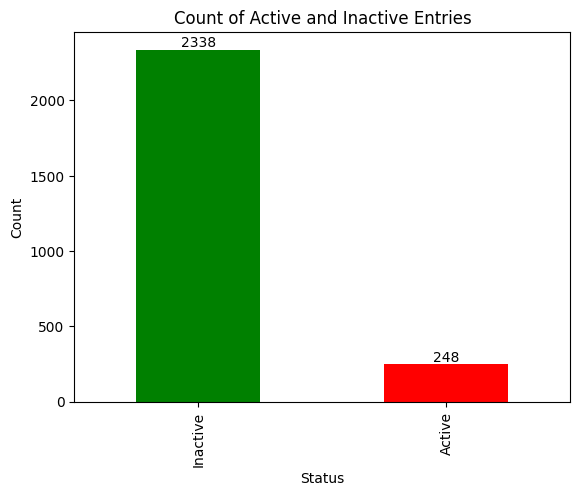

In [7]:
# Count active and inactive entries
counts = df['activity'].value_counts()

# Create a bar chart
ax = counts.plot(kind='bar', color=['green', 'red'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.title('Count of Active and Inactive Entries')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [8]:
df = df.drop_duplicates()

In [9]:
inactive=df[df['activity']=='Inactive']
sub_inactive=inactive.sample(frac=0.35, random_state=1)
rest_df=pd.concat([df[df['activity']=='Active'],sub_inactive])

In [10]:
rest_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1015 entries, 0 to 778
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Smiles    1015 non-null   object
 1   activity  1015 non-null   object
dtypes: object(2)
memory usage: 23.8+ KB


In [11]:
df=rest_df

## Making data distribution based on  project purpose (1:4 for active and decoys)

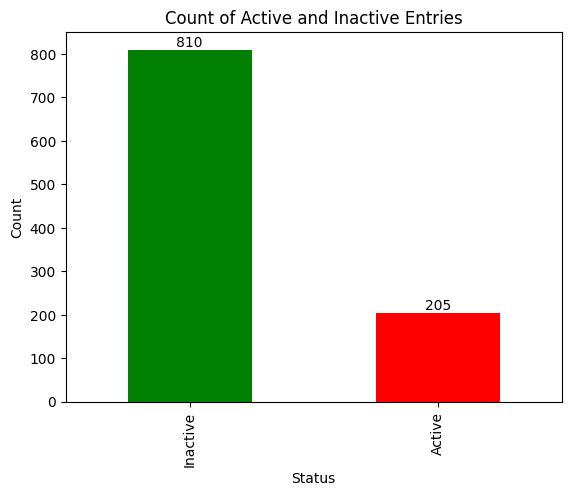

In [12]:
# Count active and inactive entries
counts = df['activity'].value_counts()

# Create a bar chart
ax = counts.plot(kind='bar', color=['green', 'red'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.title('Count of Active and Inactive Entries')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

## Data Transform and Generate Descriptors

In [13]:
from rdkit import Chem
from rdkit.Chem import Descriptors

In [14]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

# Initialize lists to store calculated properties
logP_values = []
hydrogen_donors = []
hydrogen_acceptors = []
tpsa_values = []
mw_values = []
hac_values = []
rot_bonds_values = []
fsp3_values = []
qed_values = []
slogp_values = []

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    # Convert SMILES to molecule object
    mol = Chem.MolFromSmiles(row['Smiles'])
    
    # Check if conversion was successful
    if mol is None:
        print(f"Failed to convert SMILES to molecule for index {index}. Skipping.")
        continue  # Skip this iteration and move to the next one
    
    # Calculate properties
    logP = Descriptors.MolLogP(mol)
    num_h_donors = Descriptors.NumHDonors(mol)
    num_h_acceptors = Descriptors.NumHAcceptors(mol)
    tpsa = Descriptors.TPSA(mol)
    mw = Descriptors.MolWt(mol)
    hac = Descriptors.HeavyAtomCount(mol)
    rot_bonds = Descriptors.NumRotatableBonds(mol)
    fsp3 = Descriptors.FractionCSP3(mol)
    qed = QED.qed(mol)
    slogp = Descriptors.MolLogP(mol)
    
    # Append calculated properties to lists
    logP_values.append(logP)
    hydrogen_donors.append(num_h_donors)
    hydrogen_acceptors.append(num_h_acceptors)
    tpsa_values.append(tpsa)
    mw_values.append(mw)
    hac_values.append(hac)
    rot_bonds_values.append(rot_bonds)
    fsp3_values.append(fsp3)
    qed_values.append(qed)
    slogp_values.append(slogp)

# Create a new DataFrame with only the rows that had successful conversions
valid_rows_df = df[df['Smiles'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

# Add calculated columns to the valid rows DataFrame
valid_rows_df['logP'] = logP_values[:len(valid_rows_df)]
valid_rows_df['num_H_Donors'] = hydrogen_donors[:len(valid_rows_df)]
valid_rows_df['num_H_Acceptors'] = hydrogen_acceptors[:len(valid_rows_df)]
valid_rows_df['TPSA'] = tpsa_values[:len(valid_rows_df)]
valid_rows_df['MW'] = mw_values[:len(valid_rows_df)]
valid_rows_df['HAC'] = hac_values[:len(valid_rows_df)]
valid_rows_df['RotBonds'] = rot_bonds_values[:len(valid_rows_df)]
valid_rows_df['FSP3'] = fsp3_values[:len(valid_rows_df)]
valid_rows_df['QED'] = qed_values[:len(valid_rows_df)]
valid_rows_df['SLogP'] = slogp_values[:len(valid_rows_df)]

# Print the resulting DataFrame
print(valid_rows_df.head())


                                              Smiles activity    logP  \
0                   CCCn1c2c(c3cccc(C(=O)O)c31)CCCC2   Active  3.6283   
1   O=C(O)c1cccc2c3c(n(Cc4cccc(C(F)(F)F)c4)c12)CCCC3   Active  5.2854   
2               O=C(O)CC/C=C\c1nn(-c2ccccc2)c2c1CCC2   Active  3.2390   
3  CCCCCCCCOc1ccc(S(=O)(=O)Nc2ccc(F)c(C(=O)O)c2)c...   Active  6.2172   
4  O=C(O)c1cc(NS(=O)(=O)c2ccc(OCCC3CCCCC3)c3ccccc...   Active  5.8271   

   num_H_Donors  num_H_Acceptors   TPSA       MW  HAC  RotBonds      FSP3  \
0             1                2  42.23  257.333   19         3  0.437500   
1             1                2  42.23  373.374   27         3  0.285714   
2             1                3  55.12  282.343   21         5  0.294118   
3             2                4  92.70  473.566   33        12  0.320000   
4             2                4  92.70  471.550   33         8  0.320000   

        QED   SLogP  
0  0.911947  3.6283  
1  0.678209  5.2854  
2  0.915579  3.2390  
3  0.30482

In [15]:
df=valid_rows_df

In [16]:
X = df.drop(columns=[ 'Smiles','activity'])
y = df['activity']

In [17]:
print(X)

         logP  num_H_Donors  num_H_Acceptors   TPSA       MW  HAC  RotBonds  \
0     3.62830             1                2  42.23  257.333   19         3   
1     5.28540             1                2  42.23  373.374   27         3   
2     3.23900             1                3  55.12  282.343   21         5   
3     6.21720             2                4  92.70  473.566   33        12   
4     5.82710             2                4  92.70  471.550   33         8   
...       ...           ...              ...    ...      ...  ...       ...   
2425  2.08760             1                3  69.23  322.812   22         6   
2092  3.39210             2                5  94.15  426.477   31         4   
812   1.31840             1                5  70.62  270.264   20         4   
2533  0.26152             1                3  72.80  238.292   16         1   
778   2.27434             0                6  91.32  320.329   22         3   

          FSP3       QED    SLogP  
0     0.437500 

## Feature (Descriptors) selection

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
importances = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_})
important_features = importances.sort_values(by='importance', ascending=False).set_index('feature')
print(important_features)

                 importance
feature                    
num_H_Donors       0.262752
logP               0.128177
SLogP              0.126709
TPSA               0.120411
FSP3               0.088237
QED                0.063688
MW                 0.062011
num_H_Acceptors    0.060560
HAC                0.049426
RotBonds           0.038029


## Generate Figerprints

In [20]:
rdk = []
macss = []
avalon = []
atom_pair = []
topo_torsion = []
morgan = []

for smiles in df['Smiles']:
  mol = Chem.MolFromSmiles(smiles)

  #RDKit Fingerprint Convertion
  rdk.append(np.array(Chem.RDKFingerprint(mol, maxPath=5, fpSize=2048)))

  #Molecular Access System Keys of MACCS
  macss.append(np.array(MACCSkeys.GenMACCSKeys(mol)))

  #Avalon FingerPrint
  avalon.append(np.array(pyAvalonTools.GetAvalonFP(mol, 2048)))

  #Atom Pair fingerprint
  atom_pair.append(AllChem.GetHashedAtomPairFingerprintAsBitVect(mol))

  #Topological Torsion Fingerprint
  topo_torsion.append(AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol))

  #Morgan fingerprint
  morgan.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048))

In [21]:
df['rdk_fp'] = rdk
df['macss_fp'] = macss
df['avalon_fp'] = avalon
df['atom_pair_fp'] = atom_pair
df['topo_torsion_fp'] = topo_torsion
df['morgan_fp'] = morgan

## Normalized fingerprints

In [22]:
# Initialize a StandardScaler instance
scaler = StandardScaler()

# Scale the RDKit fingerprints and replace the original column
df['rdk_fp'] = scaler.fit_transform(df['rdk_fp'].tolist()).tolist()

# Scale the MACCS fingerprints and replace the original column
df['macss_fp'] = scaler.fit_transform(df['macss_fp'].tolist()).tolist()

# Scale the Avalon fingerprints and replace the original column
df['avalon_fp'] = scaler.fit_transform(df['avalon_fp'].tolist()).tolist()

# Scale the Atom Pair fingerprints and replace the original column
df['atom_pair_fp'] = scaler.fit_transform(df['atom_pair_fp'].tolist()).tolist()

# Scale the Topological Torsion fingerprints and replace the original column
df['topo_torsion_fp'] = scaler.fit_transform(df['topo_torsion_fp'].tolist()).tolist()

# Scale the Morgan fingerprints and replace the original column
df['morgan_fp'] = scaler.fit_transform(df['morgan_fp'].tolist()).tolist()

In [23]:
df.sample(10)

,Smiles,activity,logP,num_H_Donors,num_H_Acceptors,TPSA,MW,HAC,RotBonds,FSP3,QED,SLogP,rdk_fp,macss_fp,avalon_fp,atom_pair_fp,topo_torsion_fp,morgan_fp
216,Cc1c(Cl)cccc1OCc1cc(=O)n2nc(-c3ccccc3)nc2[nH]1,Active,3.62542,1,5,72.28,366.808,26,4,0.105263,0.598335,3.62542,"[1.1926585293124616, 1.6569210765375952, -0.94...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.04...","[-0.5367225223426438, -0.1305146280547603, -0....","[-0.9853292781642987, -0.7932297795380986, -0....","[3.167429351327698, -0.09458499916791407, -0.0...","[-0.04443347457029381, -0.42292054645983207, -..."
251,O=C(O)c1cc(NS(=O)(=O)c2ccc(OCc3ccccc3)c3ccccc2...,Active,5.05690,2,4,92.70,451.475,32,7,0.041667,0.409897,5.05690,"[-0.8384629593656399, -0.6035290480399036, 1.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.04...","[-0.5367225223426438, -0.1305146280547603, -0....","[1.0148891565092275, 1.2606687567659067, -0.51...","[-0.31571343480189407, -0.09458499916791407, -...","[-0.04443347457029381, -0.42292054645983207, -..."
239,O=C(O)C1=C(C(=O)Nc2sccc2-c2nc(C3CC3)no2)CCC1,Active,3.17910,2,6,105.32,345.380,24,5,0.375000,0.862023,3.17910,"[-0.8384629593656399, -0.6035290480399036, 1.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.04...","[1.8631601216123497, -0.1305146280547603, -0.0...","[1.0148891565092275, 1.2606687567659067, 1.957...","[-0.31571343480189407, -0.09458499916791407, -...","[-0.04443347457029381, 2.3645103279345157, 3.4..."
2579,O=S(=O)(Nc1ccc(C([O-])(C(F)(F)F)C(F)(F)F)cc1)c...,Inactive,3.16760,1,3,69.23,398.304,26,4,0.200000,0.804865,3.16760,"[-0.8384629593656399, 1.6569210765375952, 1.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.04...","[-0.5367225223426438, -0.1305146280547603, -0....","[-0.9853292781642987, -0.7932297795380986, -0....","[-0.31571343480189407, -0.09458499916791407, -...","[-0.04443347457029381, -0.42292054645983207, -..."
1116,COc1cc(S(=O)(=O)[N-]c2ccccc2)ccc1NC(=O)/C=C/c1...,Inactive,4.74120,1,4,86.57,407.471,29,7,0.045455,0.573196,4.74120,"[-0.8384629593656399, -0.6035290480399036, 1.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.04...","[-0.5367225223426438, -0.1305146280547603, -0....","[-0.9853292781642987, -0.7932297795380986, -0....","[-0.31571343480189407, -0.09458499916791407, -...","[-0.04443347457029381, -0.42292054645983207, -..."
1711,CCN1C(=O)c2ccc(C(=O)Nc3cccc(C(=O)[O-])c3)cc2C1=O,Inactive,0.91830,1,5,106.61,337.311,25,4,0.111111,0.834979,0.91830,"[-0.8384629593656399, -0.6035290480399036, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.04...","[-0.5367225223426438, -0.1305146280547603, -0....","[1.0148891565092275, -0.7932297795380986, -0.5...","[-0.31571343480189407, -0.09458499916791407, -...","[-0.04443347457029381, -0.42292054645983207, -..."
2466,O=C(NC(=O)Oc1ccccc1)Nc1ccccc1C(=O)[O-],Inactive,1.37060,2,5,107.56,299.262,22,3,0.000000,0.889596,1.37060,"[-0.8384629593656399, -0.6035290480399036, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.04...","[-0.5367225223426438, -0.1305146280547603, -0....","[-0.9853292781642987, -0.7932297795380986, -0....","[-0.31571343480189407, -0.09458499916791407, -...","[-0.04443347457029381, -0.42292054645983207, -..."
1442,Cc1ccc(-c2n[n-][nH]c2=S)c(C)c1,Inactive,2.38023,1,2,42.78,204.278,14,1,0.200000,0.725123,2.38023,"[-0.8384629593656399, 1.6569210765375952, -0.9...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.04...","[-0.5367225223426438, -0.1305146280547603, -0....","[-0.9853292781642987, -0.7932297795380986, -0....","[-0.31571343480189407, -0.09458499916791407, -...","[-0.04443347457029381, -0.42292054645983207, -..."
618,O=C([O-])/C=C/c1nc(CSc2c(Cl)cccc2Cl)ccc1OCCc1c...,Inactive,5.06530,0,5,62.25,459.374,30,9,0.130435,0.330563,5.06530,"[1.1926585293124616, -0.6035290480399036, -0.9...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.04...","[-0.5367225223426438, -0.1305146280547603, -0....","[1.0148891565092275, 1.2606687567659067, -0.51...","[3.167429351327698, -0.09458499916791407, -0.0...","[-0.04443347457029381, -0.42292054645983207, -..

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1015 entries, 0 to 778
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Smiles           1015 non-null   object 
 1   activity         1015 non-null   object 
 2   logP             1015 non-null   float64
 3   num_H_Donors     1015 non-null   int64  
 4   num_H_Acceptors  1015 non-null   int64  
 5   TPSA             1015 non-null   float64
 6   MW               1015 non-null   float64
 7   HAC              1015 non-null   int64  
 8   RotBonds         1015 non-null   int64  
 9   FSP3             1015 non-null   float64
 10  QED              1015 non-null   float64
 11  SLogP            1015 non-null   float64
 12  rdk_fp           1015 non-null   object 
 13  macss_fp         1015 non-null   object 
 14  avalon_fp        1015 non-null   object 
 15  atom_pair_fp     1015 non-null   object 
 16  topo_torsion_fp  1015 non-null   object 
 17  morgan_fp        101

## Model and figerprint selection

In [25]:
additional_features = df[['logP', 'num_H_Donors', 'num_H_Acceptors', 'TPSA','MW','HAC','RotBonds','FSP3','QED','SLogP']].values
fingerprint_types = ['rdk_fp', 'macss_fp', 'avalon_fp', 'atom_pair_fp', 'topo_torsion_fp', 'morgan_fp']

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import classification_report, roc_auc_score


In [27]:
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report
import numpy as np
from sklearn.preprocessing import LabelEncoder
results = {}

# Define cross-validation parameters
k = 5  # Number of folds in K-Fold cross-validation
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)  # Stratified K-Fold cross-validator



for fp_type in fingerprint_types:
    print(f"\nTraining models for fingerprint type: {fp_type}")
#     additional_features = df[['LogP', 'TPSA', 'HBA', 'HBD','MW','HAC','RotBonds','FSP3','QED','SLog']].values
#     additional_features = np.nan_to_num(additional_features)
    X_f = np.array(df[fp_type].tolist())
#     if X_f.ndim==1:
#         X_f=X_f.reshape(-1,1)
    # Standardize features (optional but recommended)
   
    # Extract features and target
    X = np.hstack((X_f, additional_features))
#     y = df['Class']

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['activity'])

    # Dictionary to store classification reports
    classification_reports = {}

    ### Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_preds = cross_val_predict(rf, X, y, cv=kf)
    rf_report = classification_report(y, rf_preds, output_dict=True, zero_division=0)
    classification_reports['Random Forest'] = rf_report
    
    ### Gradient Boosting Machines (XGBoost)
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_preds = cross_val_predict(xgb_model, X, y, cv=kf)
    xgb_report = classification_report(y, xgb_preds, output_dict=True, zero_division=0)
    classification_reports['XGBoost'] = xgb_report
    
    ### Support Vector Machine (SVM)
    svm = SVC(kernel='linear')
    svm_preds = cross_val_predict(svm, X, y, cv=kf)
    svm_report = classification_report(y, svm_preds, output_dict=True, zero_division=0)
    classification_reports['SVM'] = svm_report
    
    ### k-Nearest Neighbors (k-NN)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn_preds = cross_val_predict(knn, X, y, cv=kf)
    knn_report = classification_report(y, knn_preds, output_dict=True, zero_division=0)
    classification_reports['k-NN'] = knn_report
    
    ### Logistic Regression
    log_reg = LogisticRegression(max_iter=2000)
    log_reg_preds = cross_val_predict(log_reg, X, y, cv=kf)
    log_reg_report = classification_report(y, log_reg_preds, output_dict=True, zero_division=0)
    classification_reports['Logistic Regression'] = log_reg_report
    
    ### Ensemble Method (Voting Classifier)
    ensemble_model = VotingClassifier(estimators=[
        ('rf', rf),
        ('xgb', xgb_model),
        ('svm', svm),
        ('knn', knn),
        ('log_reg', log_reg)
    ], voting='hard')
    ensemble_preds = cross_val_predict(ensemble_model, X, y, cv=kf)
    ensemble_report = classification_report(y, ensemble_preds, output_dict=True, zero_division=0)
    classification_reports['Ensemble'] = ensemble_report
    
    # Store results
    results[fp_type] = classification_reports

# Print results
for fp_type, model_reports in results.items():
    print(f"\nResults for {fp_type}:")
    for model, report in model_reports.items():
        print(f"\n{model} Classification Report:")
        print(pd.DataFrame(report).transpose())


Training models for fingerprint type: rdk_fp

Training models for fingerprint type: macss_fp

Training models for fingerprint type: avalon_fp

Training models for fingerprint type: atom_pair_fp

Training models for fingerprint type: topo_torsion_fp

Training models for fingerprint type: morgan_fp

Results for rdk_fp:

Random Forest Classification Report:
              precision    recall  f1-score      support
0              0.935829  0.853659  0.892857   205.000000
1              0.963768  0.985185  0.974359   810.000000
accuracy       0.958621  0.958621  0.958621     0.958621
macro avg      0.949798  0.919422  0.933608  1015.000000
weighted avg   0.958125  0.958621  0.957898  1015.000000

XGBoost Classification Report:
              precision    recall  f1-score      support
0              0.935323  0.917073  0.926108   205.000000
1              0.979115  0.983951  0.981527   810.000000
accuracy       0.970443  0.970443  0.970443     0.970443
macro avg      0.957219  0.950512  0.953

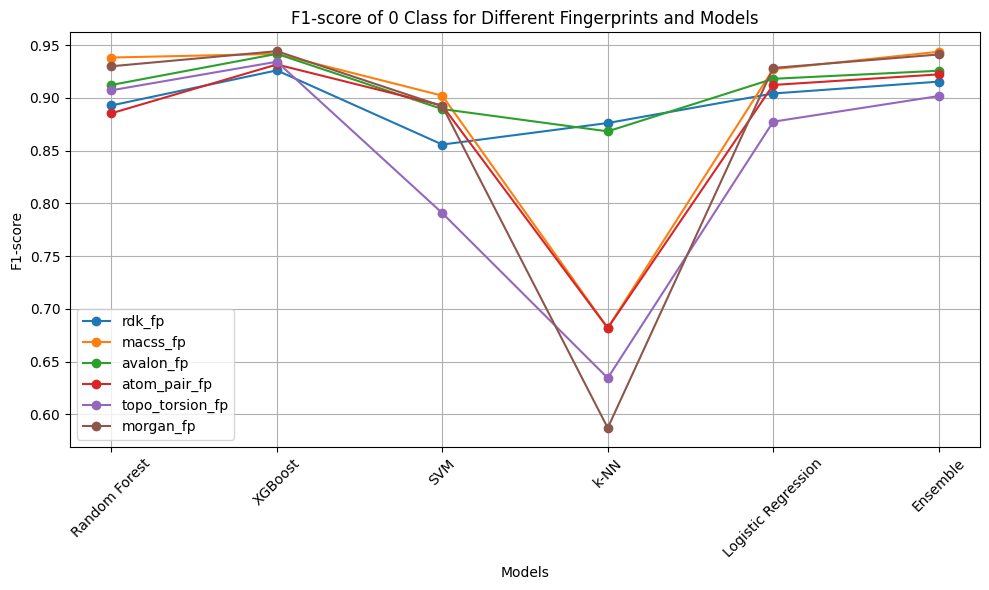

In [28]:
import matplotlib.pyplot as plt

# Data for F1-score of 0 class
fingerprints = ['rdk_fp','macss_fp', 'avalon_fp', 'atom_pair_fp', 'topo_torsion_fp', 'morgan_fp']
models = ['Random Forest', 'XGBoost', 'SVM', 'k-NN', 'Logistic Regression', 'Ensemble']

f1_scores_0 = {
    'rdk_fp':[0.892857,0.926108,0.855792,0.876190,0.904177,0.915423],
    'macss_fp': [0.938272, 0.941748, 0.902148, 0.681934, 0.927184, 0.943765],
    'avalon_fp': [0.912281, 0.941748, 0.889423, 0.868293, 0.918114, 0.925743],
    'atom_pair_fp': [0.885417, 0.931707, 0.892683, 0.681818, 0.912281, 0.922306],
    'topo_torsion_fp': [0.907216, 0.934307, 0.790805, 0.634429, 0.877451,0.901763],
    'morgan_fp': [0.930000, 0.944310, 0.892157, 0.587127, 0.928395, 0.941176]
}

# Plotting
plt.figure(figsize=(10, 6))

for fingerprint in fingerprints:
    plt.plot(models, f1_scores_0[fingerprint], marker='o', label=fingerprint)

plt.title('F1-score of 0 Class for Different Fingerprints and Models')
plt.xlabel('Models')
plt.ylabel('F1-score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


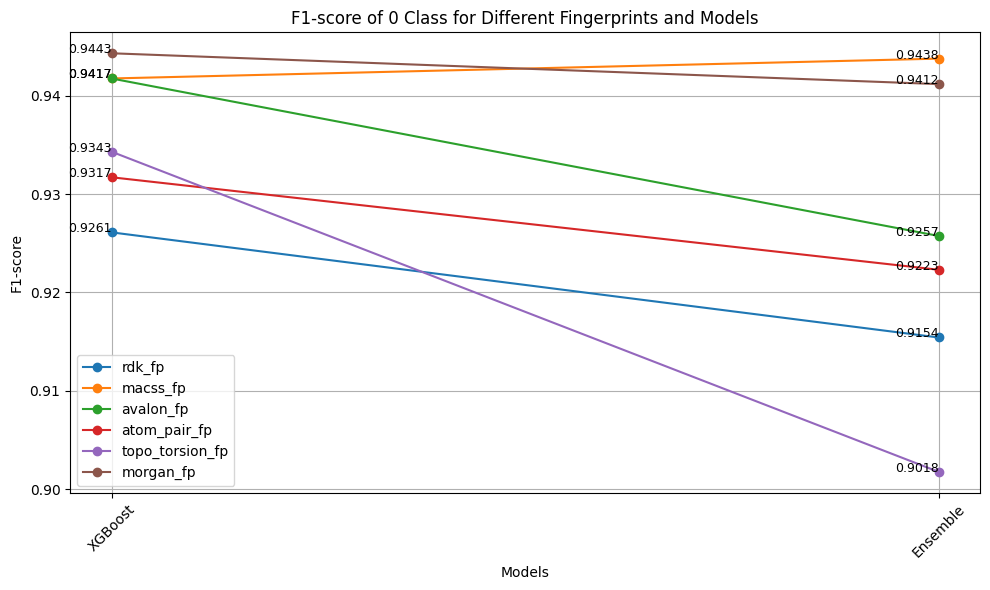

In [29]:
import matplotlib.pyplot as plt

# Data for F1-score of 0 class
fingerprints = ['rdk_fp','macss_fp', 'avalon_fp', 'atom_pair_fp', 'topo_torsion_fp', 'morgan_fp']
models = ['XGBoost', 'Ensemble']

f1_scores_0 = {
    'rdk_fp': [0.926108, 0.915423],
    'macss_fp': [0.941748, 0.943765],
    'avalon_fp': [0.941748, 0.925743],
    'atom_pair_fp': [0.931707, 0.922306],
    'topo_torsion_fp': [0.934307, 0.901763],
    'morgan_fp': [0.944310, 0.941176]
}

# Plotting
plt.figure(figsize=(10, 6))

for fingerprint in fingerprints:
    scores = f1_scores_0[fingerprint]
    plt.plot(models, scores, marker='o', label=fingerprint)
    for i, score in enumerate(scores):
        plt.text(models[i], score, f'{score:.4f}', fontsize=9, ha='right')

plt.title('F1-score of 0 Class for Different Fingerprints and Models')
plt.xlabel('Models')
plt.ylabel('F1-score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


## Hyperparameter Optimization and Performance Evaluation of XGBoost Model Using Optuna and SMOTE-Tomek for Imbalanced Classification

In [30]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [31]:
import optuna

In [32]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1015 entries, 0 to 778
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Smiles           1015 non-null   object 
 1   activity         1015 non-null   object 
 2   logP             1015 non-null   float64
 3   num_H_Donors     1015 non-null   int64  
 4   num_H_Acceptors  1015 non-null   int64  
 5   TPSA             1015 non-null   float64
 6   MW               1015 non-null   float64
 7   HAC              1015 non-null   int64  
 8   RotBonds         1015 non-null   int64  
 9   FSP3             1015 non-null   float64
 10  QED              1015 non-null   float64
 11  SLogP            1015 non-null   float64
 12  rdk_fp           1015 non-null   object 
 13  macss_fp         1015 non-null   object 
 14  avalon_fp        1015 non-null   object 
 15  atom_pair_fp     1015 non-null   object 
 16  topo_torsion_fp  1015 non-null   object 
 17  morgan_fp        101

In [34]:
print(len(df))

1015


In [37]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# Swap the encoding if 'active' is encoded as 0 and 'inactive' as 1
if label_mapping['Active'] == 0:
    y = 1 - y


In [52]:

X_morgan = np.array(df['morgan_fp'].tolist())
X = np.hstack((X_morgan, additional_features))
# y = df['activity']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['activity'])
# # Map string class names to integers
# class_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
# y_mapped = np.array([class_mapping[label] for label in y])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# Swap the encoding if 'active' is encoded as 0 and 'inactive' as 1
# if label_mapping['Active'] == 0:
#     y = 1 - y

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Define the objective function for Optuna
def objective(trial):
    params = {
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'early_stopping_rounds': 10,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    
    xgb_model = XGBClassifier(**params)
    
    # Apply SMOTE + Tomek Links to the training set
    smote_tomek = SMOTETomek(random_state=42)
    X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)
    
    # Perform StratifiedKFold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_true_all = []
    y_pred_all = []
    
    for train_index, val_index in kf.split(X_train_res, y_train_res):
        X_train_fold, X_val_fold = X_train_res[train_index], X_train_res[val_index]
        y_train_fold, y_val_fold = y_train_res[train_index], y_train_res[val_index]
        
        xgb_model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
        
        y_pred = xgb_model.predict(X_val_fold)
        y_true_all.extend(y_val_fold)
        y_pred_all.extend(y_pred)
    
    # Calculate and return the weighted F1 score
    return classification_report(y_true_all, y_pred_all, target_names=np.unique(y), output_dict=True)['weighted avg']['f1-score']

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters found by Optuna:")
print(study.best_params)

# Train and evaluate the model with the best hyperparameters
best_params = study.best_params
final_model = XGBClassifier(**best_params)

# Apply SMOTE + Tomek Links to the training set
smote_tomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)

# Collect training and validation losses
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_losses = []
val_losses = []

for train_index, val_index in kf.split(X_train_res, y_train_res):
    X_train_fold, X_val_fold = X_train_res[train_index], X_train_res[val_index]
    y_train_fold, y_val_fold = y_train_res[train_index], y_train_res[val_index]
    
    final_model.fit(X_train_fold, y_train_fold, eval_set=[(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)], verbose=False)
    
    # Store the training and validation losses
    train_loss = final_model.evals_result()['validation_0']['logloss']
    val_loss = final_model.evals_result()['validation_1']['logloss']
    train_losses.append(train_loss)
    val_losses.append(val_loss)



[I 2024-07-03 12:07:27,288] A new study created in memory with name: no-name-27f2393a-35c0-4717-9679-d5d6011289a7
[I 2024-07-03 12:11:20,929] Trial 0 finished with value: 0.9807098650583617 and parameters: {'reg_alpha': 0.004677925355125685, 'reg_lambda': 0.01849843311177078, 'learning_rate': 0.0037469646520419428, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 831, 'subsample': 0.5088107315930078, 'colsample_bytree': 0.5431371469614829}. Best is trial 0 with value: 0.9807098650583617.
[I 2024-07-03 12:12:31,743] Trial 1 finished with value: 0.9691346263765575 and parameters: {'reg_alpha': 1.6106314974413274, 'reg_lambda': 0.006922147129674966, 'learning_rate': 0.000185794193805667, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 304, 'subsample': 0.9250806399464095, 'colsample_bytree': 0.8146576538638617}. Best is trial 0 with value: 0.9807098650583617.
[I 2024-07-03 12:13:09,925] Trial 2 finished with value: 0.9722211637389019 and parameters: {'reg_alpha': 0.0011716109

Best hyperparameters found by Optuna:
{'reg_alpha': 0.002219196279166775, 'reg_lambda': 0.0035855517398836103, 'learning_rate': 0.01801612626896881, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 169, 'subsample': 0.9982495029380353, 'colsample_bytree': 0.6718873010556929}


## Checking overfitting

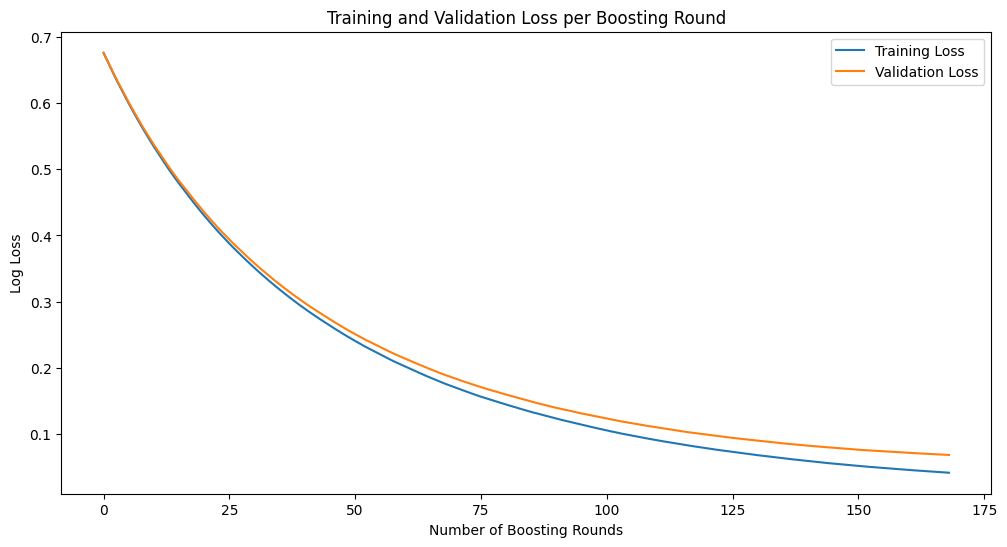

In [53]:
# Aggregate and plot the training and validation losses
plt.figure(figsize=(12, 6))

# Average the losses across folds
train_losses_mean = np.mean(train_losses, axis=0)
val_losses_mean = np.mean(val_losses, axis=0)

plt.plot(train_losses_mean, label='Training Loss')
plt.plot(val_losses_mean, label='Validation Loss')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss per Boosting Round')
plt.legend()
plt.show()

## Use best parameter for train data

In [54]:
# Train the final model with the best hyperparameters on the entire training set
best_params = study.best_params
best_params.update({
#     'random_state': 42,
#     'use_label_encoder': False,
#     'eval_metric': 'mlogloss',
#     'scale_pos_weight': scale_pos_weight,

})
class_names = label_encoder.classes_
final_model = XGBClassifier(**best_params)

# Further split the resampled training data into new training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Apply SMOTE + Tomek Links to the training set
smote_tomek = SMOTETomek(random_state=42)


X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)
# Perform k-fold cross-validation
cv_scores = cross_val_score(final_model, X_train_res, y_train_res, cv=5, scoring='accuracy')
# # Further split the resampled training data into new training and validation sets
# X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_res, y_train_res, test_size=0.2, stratify=y_train_res, random_state=42)

# # Train the final model on the new training set
# final_model.fit(X_train_new, y_train_new, eval_set=[(X_val_new, y_val_new), (X_test, y_test)], verbose=False)

# # Further split the resampled training data into new training and validation sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, stratify=y_mapped, random_state=42)

# Train the final model on the new training set
final_model.fit(X_train_res, y_train_res, eval_set=[(X_train_res, y_train_res), (X_test, y_test)], verbose=False)



# Predict on the validation and test data
# y_val_pred = final_model.predict(X_val_new)
y_test_pred = final_model.predict(X_test)

# # Evaluate the final model on the validation and test sets
# print("Final XGBoost Classification Report on Validation Set:")
# print(classification_report(y_val_new, y_val_pred, target_names=np.unique(y)))

print("Final XGBoost Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# val_accuracy = accuracy_score(y_val_new, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# print(f"Training Accuracy: {train_accuracy}")
# # print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# # Plot training vs. validation loss curves
# results = final_model.evals_result()
# epochs = len(results['validation_0']['mlogloss'])
# x_axis = range(0, epochs)

# # Plot log loss
# fig, ax = plt.subplots()
# ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
# ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
# ax.legend()
# plt.ylabel('Log Loss')
# plt.title('XGBoost Log Loss')
# plt.show()

Final XGBoost Classification Report on Test Set:
              precision    recall  f1-score   support

      Active       0.95      1.00      0.98        41
    Inactive       1.00      0.99      0.99       162

    accuracy                           0.99       203
   macro avg       0.98      0.99      0.98       203
weighted avg       0.99      0.99      0.99       203

Test Accuracy: 0.9901477832512315


In [56]:
from sklearn.metrics import confusion_matrix

# Assuming final_model is your trained XGBoost model, and X_test, y_test are your test set
y_test_pred = final_model.predict(X_test)

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 41   0]
 [  2 160]]


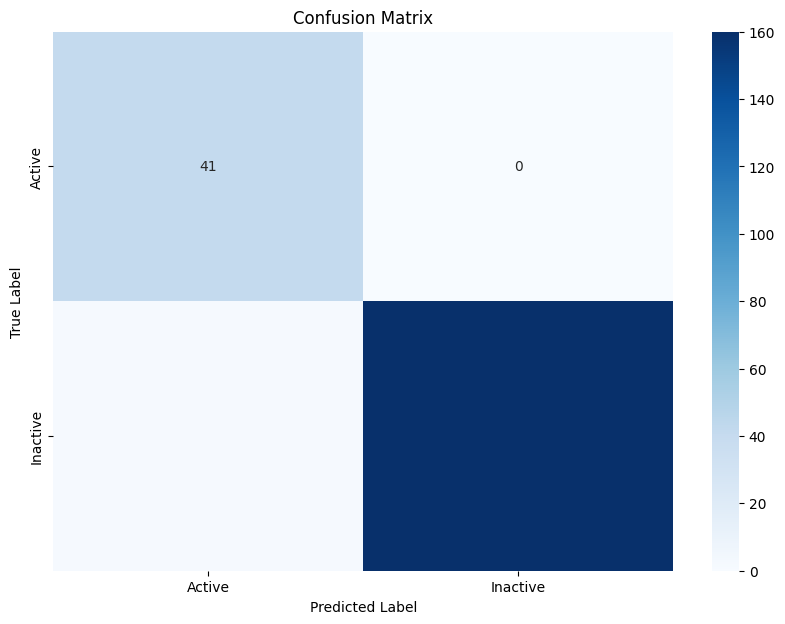

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [63]:
from sklearn.metrics import roc_auc_score

# Assuming y_pred_proba contains predicted probabilities for each class
# and y_test contains true binary labels (0 or 1)

# Directly compute the ROC-AUC score for binary classification
roc_auc_binary = roc_auc_score(y_test, y_pred_proba[:, 1])  # Assuming the second column corresponds to the positive class

print(f"ROC-AUC Score (Binary Classification): {roc_auc_binary:.4f}")


ROC-AUC Score (Binary Classification): 0.9992


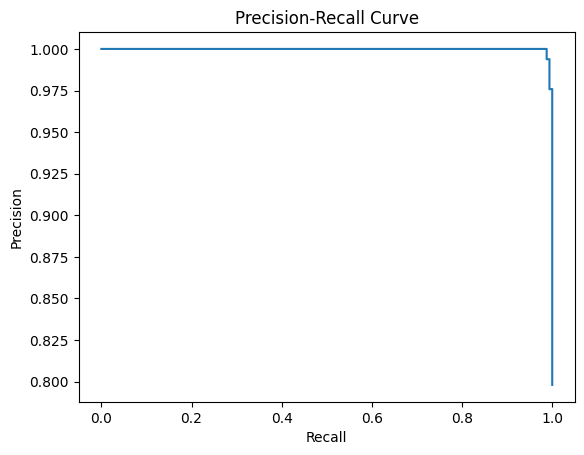

AUC-PR: 0.9998


In [65]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Extract probabilities for the positive class
positive_probs = y_pred_proba[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, positive_probs)

# Calculate AUC-PR
auc_pr = auc(recall, precision)

# Plot Precision-Recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Print AUC-PR
print(f"AUC-PR: {auc_pr:.4f}")


## Saved Trained model

In [66]:
import joblib

# Assuming best_xgb_model is your trained XGBoost model
joblib.dump(final_model, 'FABP4.joblib')

['FABP4.joblib']